# Preliminary Steps

## Initialize

In [2]:
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 3.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from time import mktime
from datetime import datetime, timedelta
import sklearn
from sklearn.model_selection import GridSearchCV
import torch
from kan import *

# First Approach: a single classifier for all the stocks at the same time

## Data Preparation

### Generate

In [ ]:
data = pd.read_csv('sp500_joined_closes (3).csv').dropna(axis=1)
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')

col_names = []
for i,col in enumerate(data.columns):
  if col.endswith(' '):
     s = f"{col[:-1]}"
  else:
     s = f"{col}"
  col_names.append(s)
data.columns = col_names
col_stocks = data.columns[1:]

# Adding features

oil = pd.read_csv('Crude Oil WTI Futures Historical Data.csv')
oil['Date'] = pd.to_datetime(oil['Date'],format='%m/%d/%Y')
oil = oil[['Date','Price']]
oil = oil.rename(columns={'Price':'Oil'})

gold = pd.read_csv('Gold Futures Historical Data.csv')
gold['Date'] = pd.to_datetime(gold['Date'],format='%m/%d/%Y')
gold = gold[['Date','Price']]
gold = gold.rename(columns={'Price':'Gold'})
gold['Gold'] = gold['Gold'].str.replace(',', '').astype(float)

rf = pd.read_csv('Federal Funds Composite Interest Rate Historical Data.csv')
rf['Date'] = pd.to_datetime(rf['Date'],format='%m/%d/%Y')
rf = rf[['Date','Price']]
rf = rf.rename(columns={'Price': 'RF'})

semiconductor = pd.read_csv('Philadelphia Semiconductor Index Historical Data.csv')
semiconductor['Date'] = pd.to_datetime(semiconductor['Date'],format='%m/%d/%Y')
semiconductor = semiconductor[['Date','Price']]
semiconductor = semiconductor.rename(columns={'Price':'Semiconductor'})
semiconductor['Semiconductor'] = semiconductor['Semiconductor'].str.replace(',', '').astype(float)

wheat = pd.read_csv('US Wheat Futures Historical Data.csv')
wheat['Date'] = pd.to_datetime(wheat['Date'],format='%m/%d/%Y')
wheat = wheat[['Date','Price']]
wheat = wheat.rename(columns={'Price':'Wheat'})
wheat['Wheat'] = wheat['Wheat'].str.replace(',', '').astype(float)

yuan = pd.read_csv('USD_CNY Historical Data.csv')
yuan['Date'] = pd.to_datetime(yuan['Date'],format='%m/%d/%Y')
yuan = yuan[['Date','Price']]
yuan = yuan.rename(columns={'Price':'Yuan'})

data = pd.merge(data, oil, on='Date')
data = pd.merge(data, gold, on='Date')
data = pd.merge(data, semiconductor, on='Date')
data = pd.merge(data, wheat, on='Date')
data = pd.merge(data, yuan, on='Date')

# Weekly data

col_stocks = data.columns.values[[i for i,col in enumerate(data.columns) if not col.endswith("_VOL")]]
col_vol = data.columns.values[[i for i,col in enumerate(data.columns) if col.endswith("_VOL")]]
data_weekly = pd.DataFrame([], columns = col_stocks)
volumes = pd.DataFrame([], columns = col_vol)
vol_week = pd.DataFrame(np.zeros((1, len(col_vol))), columns = col_vol)

for i in range(data.shape[0]-1):
  date1 = data['Date'].iloc[i]
  date2 = data['Date'].iloc[i+1]
  dt1 = date1
  dt2 = date2
  vol_week += data[col_vol].iloc[i]

  if dt2 > (dt1 + timedelta(days=1)):
    data_weekly = pd.concat([data_weekly, data[col_stocks].iloc[[i]]], ignore_index = True)
    volumes = pd.concat([volumes, vol_week], ignore_index = True)
    vol_week = pd.DataFrame(np.zeros((1, len(col_vol))), columns = col_vol)
  elif i == data.shape[0]-2:
    data_weekly = pd.concat([data_weekly, data[col_stocks].iloc[[i+1]]], ignore_index = True)
    volumes = pd.concat([volumes, vol_week], ignore_index = True)
    vol_week = pd.DataFrame(np.zeros((1, len(col_vol))), columns = col_vol)
data.set_index('Date', inplace=True)
data_weekly.set_index('Date', inplace=True)
col_stocks = data_weekly.columns.values[[i for i,col in enumerate(data_weekly.columns) if not col.endswith("_VOL")]]
data_weekly[col_stocks] = np.log(data_weekly[col_stocks]/data_weekly[col_stocks].shift(1)).dropna()
data_weekly

C:\Users\pietr\AppData\Local\Temp\ipykernel_14200\3360684702.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_weekly = pd.concat([data_weekly, data[col_stocks].iloc[[i]]], ignore_index = True)
C:\Users\pietr\AppData\Local\Temp\ipykernel_14200\3360684702.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  volumes = pd.concat([volumes, vol_week], ignore_index = True)


,MMM,AOS,ABT,ACN,ADBE,AMD,AES,AFL,A,APD,...,WYNN,XEL,YUM,ZBRA,ZBH,Oil,Gold,Semiconductor,Wheat,Yuan
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-15,-0.011331,-0.020276,0.015238,0.005622,-0.022603,-0.064609,0.018692,0.033827,-0.012086,0.011300,...,0.037576,0.029386,0.032846,0.011169,-0.003879,-0.059115,-0.007403,-0.064593,-0.108175,-0.000088
2010-01-22,-0.022931,-0.023021,-0.017819,-0.014825,-0.042426,-0.114959,-0.075424,-0.040121,-0.042288,-0.058460,...,-0.097511,-0.026984,-0.039456,-0.016619,-0.018964,-0.045373,-0.036758,-0.045098,-0.023314,0.000000
2010-01-29,-0.012225,-0.003809,-0.029225,-0.028618,-0.062408,-0.054772,-0.030412,-0.013740,-0.039865,-0.027399,...,-0.032905,-0.002883,-0.002336,-0.050431,-0.073080,-0.022384,-0.005429,-0.041518,-0.051491,-0.000015
2010-02-05,-0.024525,-0.021124,0.019270,-0.011039,0.014446,-0.014855,-0.073925,-0.016237,0.039865,-0.101332,...,-0.008276,-0.031780,-0.036617,0.032790,-0.015929,-0.023599,-0.029020,0.012262,0.002111,0.000234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,-0.047648,-0.010560,-0.001346,-0.008601,-0.016687,0.011426,-0.017540,-0.002006,-0.023419,0.007244,...,-0.022675,-0.032958,-0.023814,0.028255,-0.031872,-0.029664,-0.034859,0.046638,0.068250,0.002641
2024-05-31,0.004704,-0.013538,-0.017076,-0.064142,-0.066685,0.003241,0.032003,0.024556,-0.144342,0.007868,...,0.002744,0.031696,-0.001600,-0.045868,-0.010883,-0.009437,0.000171,-0.018852,-0.027260,-0.000138
2024-06-07,0.007164,-0.031086,0.051401,0.021413,0.045427,0.005795,-0.083019,-0.012090,0.019515,0.046985,...,-0.018509,-0.012887,0.018313,-0.037547,-0.015844,-0.019146,-0.008906,0.031471,-0.044067,0.000828


In [ ]:
volumes['Date'] = data_weekly.index
volumes.set_index('Date', inplace=True)
volumes

C:\Users\pietr\AppData\Local\Temp\ipykernel_14200\3149911822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volumes['Date'] = data_weekly.index


,MMM _VOL,AOS _VOL,ABT _VOL,ACN _VOL,ADBE _VOL,AMD _VOL,AES _VOL,AFL _VOL,A _VOL,APD _VOL,...,WST _VOL,WDC _VOL,WY _VOL,WMB _VOL,WTW _VOL,WYNN _VOL,XEL _VOL,YUM _VOL,ZBRA _VOL,ZBH _VOL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,18717401.0,2941200.0,57540643.0,22332500.0,24903900.0,146722300.0,29717600.0,28984200.0,21862064.0,5227068.0,...,1402800.0,16743100.0,4872800.0,36871442.0,1363832.0,15349000.0,14714500.0,28526629.0,606600.0,6031062.0
2010-01-22,15863026.0,3350400.0,45997083.0,13891600.0,21384200.0,129838700.0,18820000.0,21805400.0,14933576.0,4815423.0,...,578000.0,24088900.0,4917200.0,42622792.0,822685.0,8623900.0,10523100.0,15572523.0,601900.0,4376676.0
2010-01-29,27220003.0,8232600.0,81720091.0,21078400.0,37010300.0,137881100.0,45496600.0,44964200.0,21527802.0,9251198.0,...,1193800.0,24487000.0,8931800.0,53696517.0,2451183.0,11245300.0,15542400.0,22938565.0,1141000.0,12277497.0
2010-02-05,26843742.0,5092800.0,91449771.0,19832900.0,42505000.0,123089700.0,39576100.0,57687200.0,33734858.0,17134067.0,...,1161600.0,19978300.0,13171100.0,57787169.0,2896783.0,11317900.0,15884400.0,39501618.0,993000.0,9129920.0
2010-02-12,26398710.0,5309400.0,84549395.0,22026700.0,57602100.0,98312800.0,41777000.0,47986600.0,33770647.0,19135646.0,...,1364400.0,19402700.0,8364500.0,52931796.0,1196825.0,10613000.0,16262700.0,36774146.0,2937000.0,9209127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,18821000.0,3397900.0,27808700.0,11291200.0,10976300.0,269734400.0,35177400.0,8182500.0,4924100.0,7743300.0,...,2655100.0,21968200.0,14997000.0,26319000.0,1661900.0,6405500.0,15990700.0,6505200.0,1330400.0,4998800.0
2024-05-31,35462200.0,5519600.0,22774400.0,19900000.0,17884500.0,233844700.0,31178100.0,9978200.0,13441700.0,6071400.0,...,2256600.0,26291800.0,13919900.0,22704700.0,2685200.0,7404100.0,20073900.0,7254200.0,1260600.0,7875800.0
2024-06-07,20758300.0,3184300.0,30599900.0,15087500.0,16365500.0,259772000.0,32958000.0,9669300.0,13350900.0,7926300.0,...,2167000.0,23004900.0,15885100.0,29355600.0,1500100.0,6665900.0,15349500.0,8683300.0,1123200.0,5740200.0


In [ ]:
data_weekly = data_weekly.dropna()
data_weekly.describe()

,MMM,AOS,ABT,ACN,ADBE,AMD,AES,AFL,A,APD,...,WYNN,XEL,YUM,ZBRA,ZBH,Oil,Gold,Semiconductor,Wheat,Yuan
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,...,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.001051,0.003436,0.002203,0.002825,0.003458,0.003642,0.000881,0.002133,0.002498,0.002143,...,0.000921,0.001872,0.002567,0.003086,0.000879,-0.000019,0.000941,0.003584,0.000069,0.000079
std,0.030087,0.036536,0.029107,0.032636,0.040476,0.074680,0.042206,0.036179,0.036806,0.031767,...,0.061440,0.027181,0.031880,0.048927,0.035620,0.051072,0.021280,0.036354,0.045139,0.004697
min,-0.132749,-0.177273,-0.182934,-0.159838,-0.276214,-0.294184,-0.257619,-0.260665,-0.152771,-0.160718,...,-0.333196,-0.277757,-0.300767,-0.230459,-0.238163,-0.346863,-0.101346,-0.173361,-0.212444,-0.020092
25%,-0.012689,-0.015359,-0.013808,-0.011699,-0.015696,-0.041791,-0.019376,-0.013070,-0.016810,-0.014021,...,-0.027424,-0.011976,-0.012147,-0.022468,-0.015970,-0.024864,-0.010545,-0.016475,-0.025456,-0.001745
50%,0.002298,0.004499,0.002276,0.004752,0.003605,0.003064,0.000753,0.003573,0.003853,0.002571,...,0.003189,0.003718,0.003496,0.003690,0.001620,0.002791,0.001862,0.005740,-0.000073,-0.000029
75%,0.018065,0.024367,0.018315,0.020609,0.025499,0.046359,0.025106,0.019339,0.024521,0.019402,...,0.031900,0.016675,0.019803,0.028937,0.019450,0.025487,0.013431,0.027128,0.022605,0.001822
max,0.111730,0.139487,0.113842,0.156467,0.177205,0.390539,0.184498,0.280926,0.147853,0.161564,...,0.376174,0.149087,0.238756,0.199975,0.181850,0.275756,0.090362,0.138663,0.469410,0.028903


In [ ]:
df1 = pd.concat([data_weekly, volumes], axis=1)
df1.to_csv('weekly_data.csv')

### Import

In [4]:
df1 = pd.read_csv('weekly_data.csv', index_col=0)
col_stocks = df1.columns.values[[i for i,col in enumerate(df1.columns) if not col.endswith("_VOL")]]
col_vol = df1.columns.values[[i for i,col in enumerate(df1.columns) if col.endswith("_VOL")]]
data_weekly = df1[col_stocks]
volumes = df1[col_vol]

### Operations

In [67]:
names = data_weekly.columns.values
targets = pd.DataFrame([], columns=names)
for name in names:
    targets[name] = (data_weekly[name].shift(-1)>0).astype(int)
targets = targets.iloc[:-1]
data_weekly = data_weekly.iloc[:-1]
targets

,MMM,AOS,ABT,ACN,ADBE,AMD,AES,AFL,A,APD,...,WYNN,XEL,YUM,ZBRA,ZBH,Oil,Gold,Semiconductor,Wheat,Yuan
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-29,0,0,1,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,1,1
2010-02-05,1,1,0,0,0,1,1,0,1,0,...,1,1,1,1,1,1,1,1,1,1
2010-02-12,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-17,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,1,1
2024-05-24,1,0,0,0,0,1,1,1,0,1,...,1,1,0,0,0,0,1,0,0,0
2024-05-31,1,0,1,1,1,1,0,0,1,1,...,0,0,1,0,0,0,0,1,0,1


In [68]:
Y = pd.DataFrame({'buy': targets.mean(axis=1).round(0), 'conf': np.zeros(targets.shape[0])})
for i in range(Y.shape[0]):
    if Y['buy'].iloc[i] == 1:
        Y['conf'].iloc[i] = sum(targets.iloc[i,:])/430
    else:
        Y['conf'].iloc[i] = 1 - sum(targets.iloc[i,:])/430
Y

,buy,conf
Date,,
2010-01-15,0.0,0.895349
2010-01-22,0.0,0.769767
2010-01-29,0.0,0.662791
2010-02-05,1.0,0.693023
2010-02-12,1.0,0.918605
...,...,...
2024-05-17,0.0,0.744186
2024-05-24,1.0,0.525581
2024-05-31,0.0,0.602326


In [69]:
df = pd.merge(data_weekly.reset_index(), Y.reset_index()).drop(columns='conf').set_index('Date')
df

,MMM,AOS,ABT,ACN,ADBE,AMD,AES,AFL,A,APD,...,XEL,YUM,ZBRA,ZBH,Oil,Gold,Semiconductor,Wheat,Yuan,buy
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,-0.011331,-0.020276,0.015238,0.005622,-0.022603,-0.064609,0.018692,0.033827,-0.012086,0.011300,...,0.029386,0.032846,0.011169,-0.003879,-0.059115,-0.007403,-0.064593,-0.108175,-0.000088,0.0
2010-01-22,-0.022931,-0.023021,-0.017819,-0.014825,-0.042426,-0.114959,-0.075424,-0.040121,-0.042288,-0.058460,...,-0.026984,-0.039456,-0.016619,-0.018964,-0.045373,-0.036758,-0.045098,-0.023314,0.000000,0.0
2010-01-29,-0.012225,-0.003809,-0.029225,-0.028618,-0.062408,-0.054772,-0.030412,-0.013740,-0.039865,-0.027399,...,-0.002883,-0.002336,-0.050431,-0.073080,-0.022384,-0.005429,-0.041518,-0.051491,-0.000015,0.0
2010-02-05,-0.024525,-0.021124,0.019270,-0.011039,0.014446,-0.014855,-0.073925,-0.016237,0.039865,-0.101332,...,-0.031780,-0.036617,0.032790,-0.015929,-0.023599,-0.029020,0.012262,0.002111,0.000234,1.0
2010-02-12,0.008115,0.051654,-0.000742,-0.001234,-0.041114,0.068358,0.003404,-0.004800,0.027390,-0.001604,...,0.004955,0.011457,0.083886,0.032132,0.040468,0.034724,0.039221,0.023965,0.000717,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-17,0.062021,-0.008137,-0.006225,-0.008985,0.002361,0.079374,0.065040,0.026255,0.029411,0.047354,...,0.001081,0.028934,0.006596,-0.009359,0.022740,0.017864,0.035751,0.008481,-0.000374,0.0
2024-05-24,-0.047648,-0.010560,-0.001346,-0.008601,-0.016687,0.011426,-0.017540,-0.002006,-0.023419,0.007244,...,-0.032958,-0.023814,0.028255,-0.031872,-0.029664,-0.034859,0.046638,0.068250,0.002641,1.0
2024-05-31,0.004704,-0.013538,-0.017076,-0.064142,-0.066685,0.003241,0.032003,0.024556,-0.144342,0.007868,...,0.031696,-0.001600,-0.045868,-0.010883,-0.009437,0.000171,-0.018852,-0.027260,-0.000138,0.0


buy
0.0    305
1.0    462
dtype: int64


<Axes: title={'center': 'Distribution of target'}, xlabel='buy'>

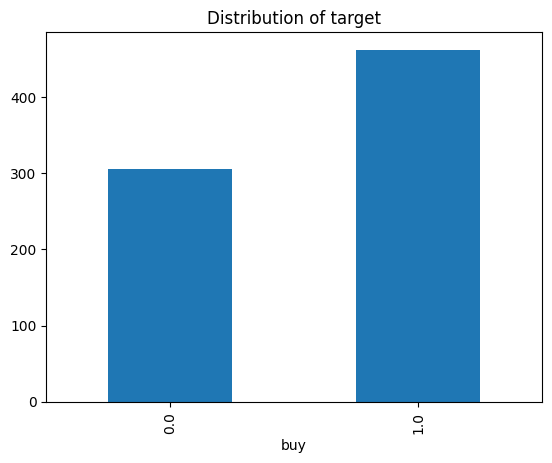

In [70]:
target_dist=df.groupby('buy').size()
print(target_dist)
target_dist.plot.bar(x='',y='',title='Distribution of target')

In [71]:
# Separate X and y (explanatory variables and target variable)
X = df.iloc[:,df.columns != 'buy']
y = df['buy']

from sklearn.model_selection import train_test_split

# SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size =0.30,
                                                    stratify=y,
                                                    random_state= 42
                                                   )

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(536, 435) (231, 435)
(536,) (231,)


## K-Nearest Neighbours

In [ ]:
# DEFINE YOUR CLASSIFIER and THE PARAMETERS GRID
from sklearn.neighbors import KNeighborsClassifier

# Create KNN Classifier
classifier_KNN = KNeighborsClassifier()
parameters = {'n_neighbors': np.arange(60,90)}

gs_KNN = GridSearchCV(classifier_KNN, parameters, cv=3, scoring = 'f1', verbose=90, n_jobs=-1)

# TRAIN YOUR CLASSIFIER
gs_KNN = gs_KNN.fit(X_train, y_train)

# Summarize the results of your GRIDSEARCH
print("Best score: %f using %s" % (gs_KNN.best_score_, gs_KNN.best_params_))

means = gs_KNN.cv_results_['mean_test_score']
stds = gs_KNN.cv_results_['std_test_score']
params = gs_KNN.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean %f Std (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best score: 0.752912 using {'n_neighbors': 68}
Mean 0.752636 Std (0.000714) with: {'n_neighbors': 60}
Mean 0.752636 Std (0.000714) with: {'n_neighbors': 61}
Mean 0.752636 Std (0.000714) with: {'n_neighbors': 62}
Mean 0.749990 Std (0.002582) with: {'n_neighbors': 63}
Mean 0.749990 Std (0.002582) with: {'n_neighbors': 64}
Mean 0.750581 Std (0.001793) with: {'n_neighbors': 65}
Mean 0.750581 Std (0.001793) with: {'n_neighbors': 66}
Mean 0.752035 Std (0.000818) with: {'n_neighbors': 67}
Mean 0.752912 Std (0.001795) with: {'n_neighbors': 68}
Mean 0.752035 Std (0.000818) with: {'n_neighbors': 69}
Mean 0.752912 Std (0.001795) with: {'n_neighbors': 70}
Mean 0.752035 Std (0.000818) with: {'n_neighbors': 71}
Mean 0.752035 Std (0.000818) with: {'n_neighbors': 72}
Mean 0.752035 Std (0.000818) with: {'n_neighbors': 73}
Mean 0.752035 Std (0.000818) with: {'n_neighbors': 74}
Mean 0.752035 Std (0.000818) with: {'n_neighbors': 75}
Mean 0.75203

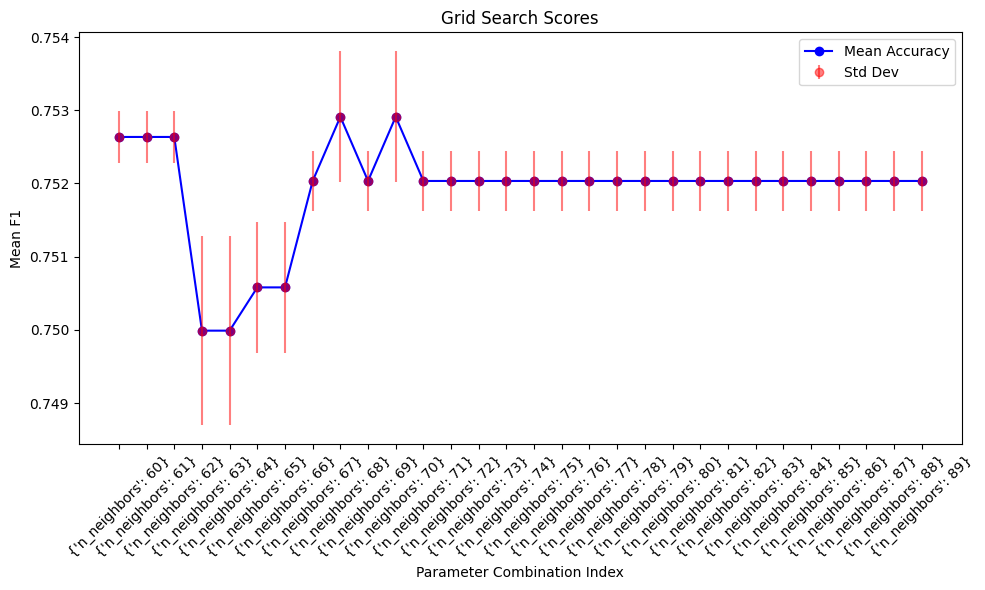

0.7529117295484432


In [ ]:
# Plot results of grid search
x_axis = range(len(params))

plt.figure(figsize=(10, 6))

# Plot mean accuracy scores
plt.plot(x_axis, means, color='blue', alpha=1.00, marker='o', label='Mean Accuracy')

# Add error bars (standard deviation)
plt.errorbar(x_axis, means, yerr=stds/2, fmt='o', color='red', alpha=0.5, label='Std Dev')

plt.title('Grid Search Scores')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean F1')
plt.xticks(x_axis, [str(p) for p in params], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(gs_KNN.best_score_)

In [ ]:
# TEST ON YOUR TEST SET
best_model = gs_KNN.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

In [ ]:
from sklearn import metrics

# EVALUATE YOUR PREDICTION IN THE TRAINING SET

print('***RESULTS ON TRAIN SET***')
print("precision: ", metrics.precision_score(y_train, y_pred_train)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_train, y_pred_train)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train)) # (tp+tn)/m

# EVALUATE YOUR PREDICTION IN THE TEST SET
print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred)) # (tp+tn)/m

# PRINT SOME FURTHER METRICS
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

***RESULTS ON TRAIN SET***
precision:  0.6033834586466166
recall:  0.9938080495356038
f1_score:  0.7508771929824561
accuracy:  0.6026119402985075
***RESULTS ON TEST SET***
precision:  0.6017316017316018
recall:  1.0
f1_score:  0.7513513513513513
accuracy:  0.6017316017316018
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        92
         1.0       0.60      1.00      0.75       139

    accuracy                           0.60       231
   macro avg       0.30      0.50      0.38       231
weighted avg       0.36      0.60      0.45       231



C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

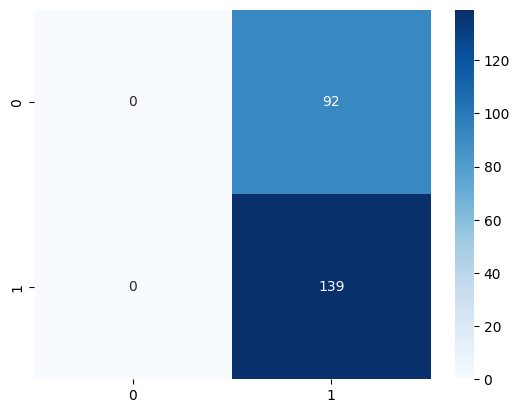

In [ ]:
# Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format


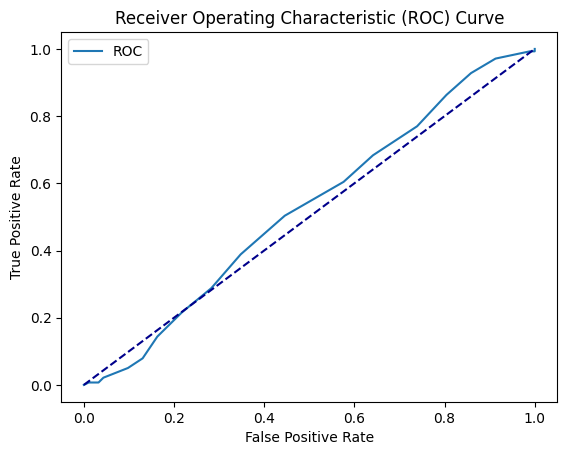

AUC: 0.52


In [ ]:
y_test_probs = best_model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_test_probs[:,1])

# plot
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_test_probs[:,1])
print('AUC: %.2f' % auc)

### Final Remark on K-NN
As we expected due to the problem's nature, KNN doesn't perform that well: it's only marginally better than a random classifier.

## Decision Trees
Based on the kind of problem, this method might work well, but it might as well be too simple

In [ ]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'],
              'max_depth': [3,5,10,50],
              'min_samples_split': [5,25,50],
              'min_samples_leaf': [2,4,10]}


gs_tree = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1)

gs_tree = gs_tree.fit(X_train, y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_tree.best_score_, gs_tree.best_params_))
means = gs_tree.cv_results_['mean_test_score']
stds = gs_tree.cv_results_['std_test_score']
params = gs_tree.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
***GRIDSEARCH RESULTS***
Best score: 0.712741 using {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5}
0.623879 (0.037137) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.620934 (0.032002) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 25}
0.624752 (0.041488) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 50}
0.629182 (0.024695) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5}
0.619742 (0.032382) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 25}
0.624752 (0.041488) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 50}
0.636689 (0.042481) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 5

***RESULTS ON TRAIN SET***
f1_score:  0.7886944818304172
--
***RESULTS ON TEST SET***
f1_score:  0.6865671641791045


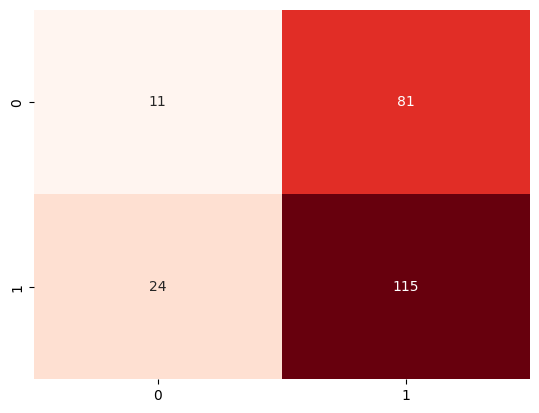

In [ ]:
#TEST ON YOUR TEST SET
best_model_tree = gs_tree.best_estimator_
y_pred_tree = best_model_tree.predict(X_test)

y_pred_train_tree = best_model_tree.predict(X_train)

# model_try = DecisionTreeClassifier(criterion='entropy', max_depth=50, min_samples_leaf=25, min_samples_split=50)
# model_try.fit(X_train, y_train)
# y_pred_tree = model_try.predict(X_test)
# y_pred_train_tree = model_try.predict(X_train)

print('***RESULTS ON TRAIN SET***')
print("f1_score: ", metrics.f1_score(y_train, y_pred_train_tree))
print("--")
print('***RESULTS ON TEST SET***')
print("f1_score: ", metrics.f1_score(y_test, y_pred_tree))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt='d', cmap="Reds", cbar=False);

In [ ]:
print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred_tree)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred_tree)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred_tree)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_tree)) # (tp+tn)/m


***RESULTS ON TEST SET***
precision:  0.5867346938775511
recall:  0.8273381294964028
f1_score:  0.6865671641791045
accuracy:  0.5454545454545454


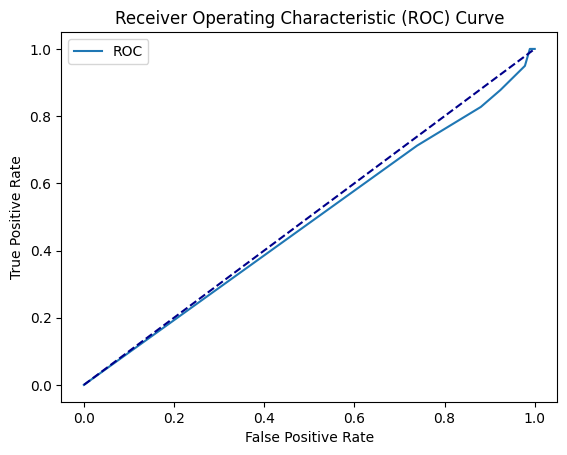

AUC: 0.48


In [ ]:
y_probs_tree = best_model_tree.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr_tree, tpr_tree, thresholds_new_tree=metrics.roc_curve(y_test,  y_probs_tree[:,1])

# plot
plt.plot(fpr_tree, tpr_tree, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs_tree[:,1])
print('AUC: %.2f' % auc)

### Final Remark on Decision Tree
This model seems to overfit

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC
classifier = SVC()
parameters = {
    "kernel": ['linear', 'rbf'],
    "C": [.01, .1, 1],
    "gamma": [1],
    # "degree": [2, 3, 4]
}

gs_svm = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)

#TRAIN YOUR CLASSIFIER
gs_svm = gs_svm.fit(X_train, y_train)
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_svm.best_score_, gs_svm.best_params_))
means = gs_svm.cv_results_['mean_test_score']
stds = gs_svm.cv_results_['std_test_score']
params = gs_svm.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
***GRIDSEARCH RESULTS***
Best score: 0.752035 using {'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
0.752035 (0.000818) with: {'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
0.752035 (0.000818) with: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
0.752035 (0.000818) with: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
0.752035 (0.000818) with: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.746738 (0.003279) with: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
0.745125 (0.009389) with: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
classifier_poly = SVC()
parameters_poly = {
    "kernel": ['poly'],
    "C": [.01, .1, 1],
    "gamma": [1],
    "degree": [2, 3, 4]
}

gs_svm_poly = GridSearchCV(classifier_poly, parameters_poly, cv=3, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)

#TRAIN YOUR CLASSIFIER
gs_svm_poly = gs_svm_poly.fit(X_train, y_train)
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_svm_poly.best_score_, gs_svm_poly.best_params_))
means = gs_svm_poly.cv_results_['mean_test_score']
stds = gs_svm_poly.cv_results_['std_test_score']
params = gs_svm_poly.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
***GRIDSEARCH RESULTS***
Best score: 0.752035 using {'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
0.752035 (0.000818) with: {'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
0.752035 (0.000818) with: {'C': 0.01, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
0.749992 (0.003784) with: {'C': 0.01, 'degree': 4, 'gamma': 1, 'kernel': 'poly'}
0.751446 (0.003673) with: {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
0.751456 (0.000818) with: {'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
0.750280 (0.003672) with: {'C': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'poly'}
0.751172 (0.001810) with: {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
0.748536 (0.001807) with: {'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
0.748532 (0.001496) with: {'C': 1, 'degree': 4, 'gamma': 1, 'kernel': 'poly'}


We can compare these two models and conclude that the best is the one using {'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}

***RESULTS ON TRAIN SET***
f1_score:  0.7508771929824561
--
***RESULTS ON TEST SET***
f1_score:  0.7513513513513513


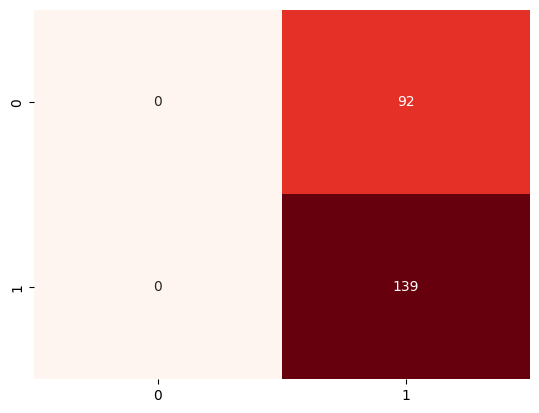

In [ ]:
#TEST ON YOUR TEST SET
best_model_svm = gs_svm_poly.best_estimator_
y_pred_svm = best_model.predict(X_test)

y_pred_train_svm = best_model.predict(X_train)

print('***RESULTS ON TRAIN SET***')
print("f1_score: ", metrics.f1_score(y_train, y_pred_train_svm))
print("--")
print('***RESULTS ON TEST SET***')
print("f1_score: ", metrics.f1_score(y_test, y_pred_svm))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap="Reds", cbar=False);

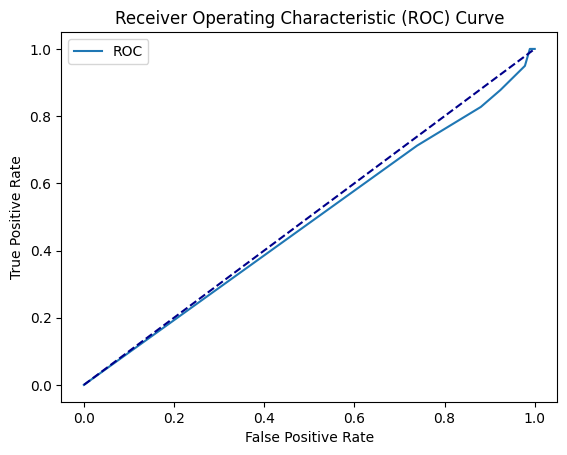

AUC: 0.52


In [ ]:
y_probs_svm = best_model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr_svm, tpr_svm, thresholds_new_svm=metrics.roc_curve(y_test,  y_probs_svm[:,1])

# plot
plt.plot(fpr_tree, tpr_tree, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs_svm[:,1])
print('AUC: %.2f' % auc)

### Remark on SVM
With this data it's almost a random classifier, just like KNN and Decision Trees.

## Multi-Layer Perceptron Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

classifier_mlp = MLPClassifier()
parameters_mlp = {"hidden_layer_sizes":[(200,100,50),(200,50)],"activation": ['logistic', 'tanh', 'relu'],  "max_iter": [500000], "alpha": [10,100]}

gs_mlp = GridSearchCV(classifier_mlp, parameters_mlp, cv=3, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)

#TRAIN YOUR CLASSIFIER
gs_mlp = gs_mlp.fit(X_train, y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_mlp.best_score_, gs_mlp.best_params_))
means = gs_mlp.cv_results_['mean_test_score']
stds = gs_mlp.cv_results_['std_test_score']
params = gs_mlp.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
***GRIDSEARCH RESULTS***
Best score: 0.752035 using {'activation': 'logistic', 'alpha': 10, 'hidden_layer_sizes': (200, 100, 50), 'max_iter': 500000}
0.752035 (0.000818) with: {'activation': 'logistic', 'alpha': 10, 'hidden_layer_sizes': (200, 100, 50), 'max_iter': 500000}
0.752035 (0.000818) with: {'activation': 'logistic', 'alpha': 10, 'hidden_layer_sizes': (200, 50), 'max_iter': 500000}
0.752035 (0.000818) with: {'activation': 'logistic', 'alpha': 100, 'hidden_layer_sizes': (200, 100, 50), 'max_iter': 500000}
0.752035 (0.000818) with: {'activation': 'logistic', 'alpha': 100, 'hidden_layer_sizes': (200, 50), 'max_iter': 500000}
0.752035 (0.000818) with: {'activation': 'tanh', 'alpha': 10, 'hidden_layer_sizes': (200, 100, 50), 'max_iter': 500000}
0.752035 (0.000818) with: {'activation': 'tanh', 'alpha': 10, 'hidden_layer_sizes': (200, 50), 'max_iter': 500000}
0.752035 (0.000818) with: {'activation': 'tanh', 'alpha': 100, 'hi

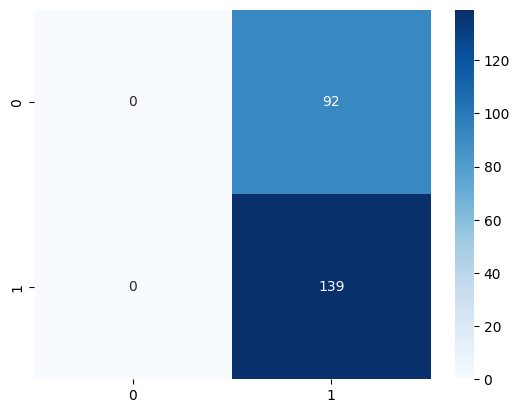

In [ ]:
#TEST ON YOUR TEST SET
best_model_mlp = gs_mlp.best_estimator_

y_pred_mlp = best_model_mlp.predict(X_test)
y_pred_train_mlp = best_model_mlp.predict(X_train)

#CONFUSION MATRIX
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap="Blues");

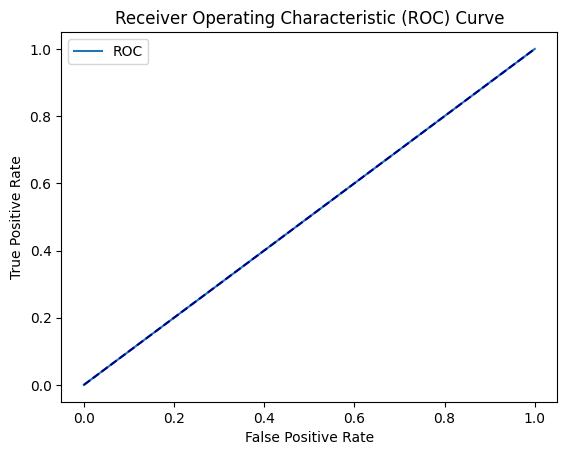

AUC: 0.50


In [ ]:
y_probs_mlp = best_model_mlp.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr_mlp, tpr_mlp, thresholds_mlp=metrics.roc_curve(y_test,  y_probs_mlp[:,1])

plt.plot(fpr_mlp, tpr_mlp, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs_mlp[:,1])
print('AUC: %.2f' % auc)

### Remark on MLP

This method performs just like a random classifier: actually, it classifies every observation as a 1, thus we can safely exclude it from our selection.

## Kolmogorov-Arnold Network

In [ ]:
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[3,10,1], grid=3, k=3, seed=42, device=device)

cuda
checkpoint directory created: ./model
saving model version 0.0


In [ ]:
X_train_kan = torch.tensor(X_train.values).to(device)
y_train_kan = torch.tensor(y_train.values).to(device)
X_test_kan = torch.tensor(X_test.values).to(device)
y_test_kan = torch.tensor(y_test.values).to(device)

In [ ]:
dataset = {
    'train_input': X_train_kan,
    'train_label': y_train_kan,
    'test_input': X_test_kan,
    'test_label': y_test_kan
}

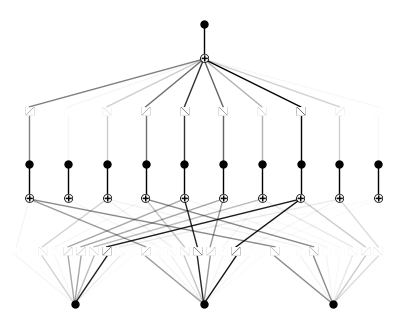

In [ ]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot()

| train_loss: 4.88e-01 | test_loss: 4.89e-01 | reg: 2.57e-01 | : 100%|█| 50/50 [00:18<00:00,  2.73it


saving model version 0.1


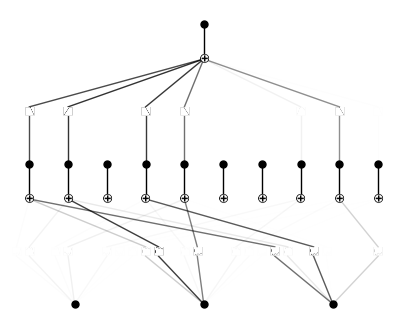

In [ ]:
# train the model
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);
model.plot()

saving model version 0.2


| train_loss: 4.88e-01 | test_loss: 4.91e-01 | reg: 7.09e+00 | : 100%|█| 50/50 [00:11<00:00,  4.32it


saving model version 0.3


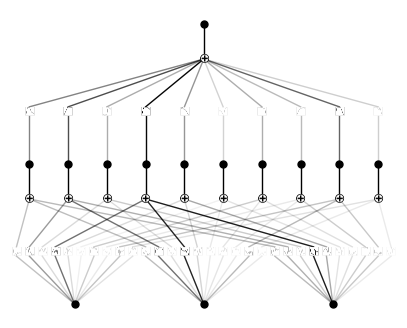

In [ ]:
model = model.refine(10)
model.fit(dataset, opt="LBFGS", steps=50);
model.plot()

saving model version 0.4


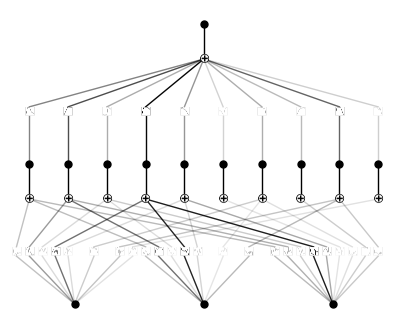

In [ ]:
model = model.prune()
model.plot()

saving model version 0.5


| train_loss: 4.88e-01 | test_loss: 4.99e-01 | reg: 1.05e+01 | : 100%|█| 50/50 [00:18<00:00,  2.76it


saving model version 0.6


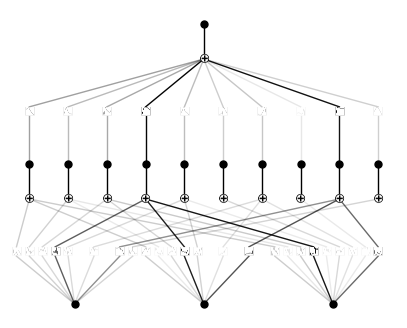

In [ ]:
model = model.refine(10)
model.fit(dataset, opt="LBFGS", steps=50);
model.plot()

In [ ]:
from kan.utils import ex_round

formula = ex_round(model.symbolic_formula()[0][0],4)
formula

0

In [ ]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0])).astype(np.float64)) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.3897, device='cuda:0')
test acc of the formula: tensor(0.3913, device='cuda:0')


In [ ]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:]) == dataset['train_label'][:]).type(torch.float64))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:]) == dataset['test_label'][:]).type(torch.float64))

results = model.fit(dataset, opt="LBFGS", steps=50, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

| train_loss: 4.88e-01 | test_loss: 5.00e-01 | reg: 1.04e+01 | : 100%|█| 50/50 [00:12<00:00,  3.86it

saving model version 0.7


(0.6103286384976525, 0.5921550094517959)

In [ ]:
formula = ex_round(model.symbolic_formula()[0][0],4)
formula

0

## Ensemble Classifiers: Adaboost
Best results so far, but too computationally heavy

C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


f1_score:  0.7076923076923077


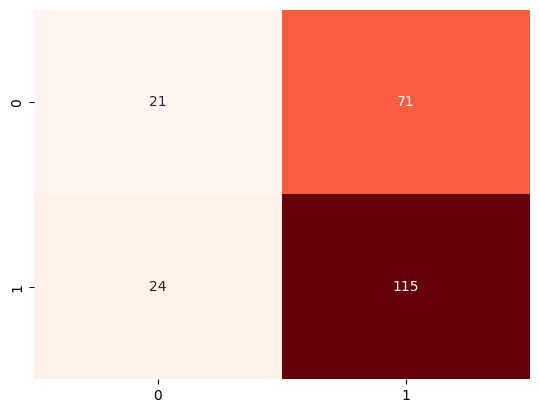

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=1000)
adaboost.fit(X_train, y_train)

y_pred_ada = adaboost.predict(X_test)
y_pred_train_ada = adaboost.predict(X_train)

print("f1_score: ", metrics.f1_score(y_test, y_pred_ada))
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_ada), annot=True, fmt='d', cmap="Reds", cbar=False);


f1_score_train:  1.0
f1_score_test:  0.7076923076923077


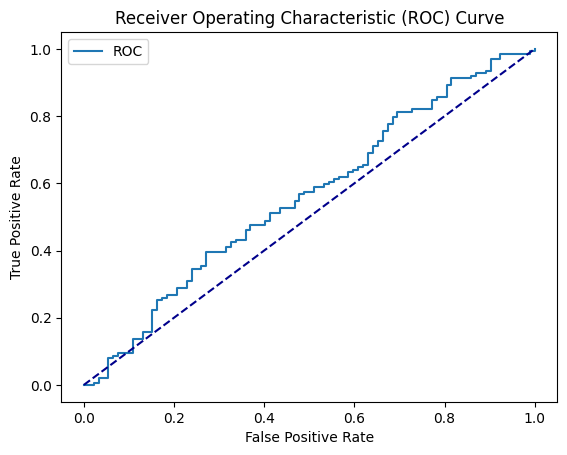

AUC: 0.56


In [ ]:
print("f1_score_train: ", metrics.f1_score(y_train, y_pred_train_ada))
print("f1_score_test: ", metrics.f1_score(y_test, y_pred_ada))

y_probs_ada = adaboost.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr_ada, tpr_ada, thresholds_ada=metrics.roc_curve(y_test,  y_probs_ada[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr_ada, tpr_ada, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs_ada[:,1])
print('AUC: %.2f' % auc)

### GridSearch

In [ ]:
# classifier= AdaBoostClassifier()
classifier= AdaBoostClassifier(DecisionTreeClassifier())
# parameters = {'n_estimators' : [1000, 5000],
#     'learning_rate' : [0.0001, 0.1, 10]}
parameters = {'estimator__max_depth':[i for i in range(3,11,5)],
              'estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,250,1000,5000],
              'learning_rate':[0.01,0.1]}

gs_ada = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

gs_ada.fit(X_train,y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_ada.best_score_, gs_ada.best_params_))
means = gs_ada.cv_results_['mean_test_score']
stds = gs_ada.cv_results_['std_test_score']
params = gs_ada.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


***GRIDSEARCH RESULTS***
Best score: 0.730904 using {'estimator__max_depth': 8, 'estimator__min_samples_leaf': 10, 'learning_rate': 0.01, 'n_estimators': 250}
0.651460 (0.031646) with: {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 5, 'learning_rate': 0.01, 'n_estimators': 10}
0.673489 (0.038085) with: {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 5, 'learning_rate': 0.01, 'n_estimators': 250}
0.692884 (0.025881) with: {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 5, 'learning_rate': 0.01, 'n_estimators': 1000}
0.696314 (0.021257) with: {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 5, 'learning_rate': 0.01, 'n_estimators': 5000}
0.640493 (0.064722) with: {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 5, 'learning_rate': 0.1, 'n_estimators': 10}
0.701654 (0.029195) with: {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 5, 'learning_rate': 0.1, 'n_estimators': 250}
0.694307 (0.013794) with: {'estimator__max_depth': 

f1_score_train:  1.0
f1_score_test:  0.7283236994219653


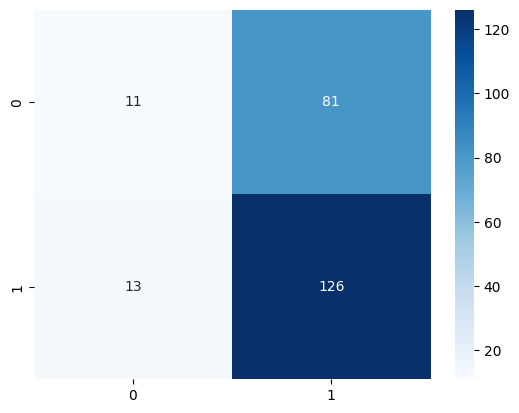

In [ ]:
#TEST ON YOUR TEST SET
best_model_ada_gs = gs_ada.best_estimator_

y_pred_ada_gs = best_model_ada_gs.predict(X_test)
y_pred_train_ada_gs = best_model_ada_gs.predict(X_train)

print("f1_score_train: ", metrics.f1_score(y_train, y_pred_train_ada_gs))
print("f1_score_test: ", metrics.f1_score(y_test, y_pred_ada_gs))

#CONFUSION MATRIX
sns.heatmap(confusion_matrix(y_test, y_pred_ada_gs), annot=True, fmt='d', cmap="Blues");

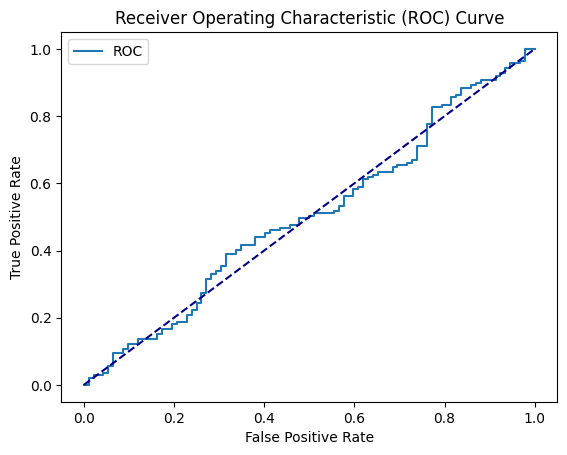

AUC: 0.50


In [ ]:
y_probs_ada_gs = best_model_ada_gs.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr_ada_gs, tpr_ada_gs, thresholds_ada_gs=metrics.roc_curve(y_test,  y_probs_ada_gs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr_ada_gs, tpr_ada_gs, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs_ada_gs[:,1])
print('AUC: %.2f' % auc)

### Remarks on Adaboost

This method increases the classifier's performance before applying the GridSearch. After doing so, it becomes once again a random classifier.

## Ensemble Classifiers: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier_forest= RandomForestClassifier()
parameters = {'n_estimators' : [50, 200],
    'criterion' : ['gini'],
             'max_depth' : [1,4],
             'min_samples_split' : [4,10],
              'min_samples_leaf' : [4,10]
             }

gs_forest = GridSearchCV(classifier_forest, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

gs_forest.fit(X_train,y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_forest.best_score_, gs_forest.best_params_))
means = gs_forest.cv_results_['mean_test_score']
stds = gs_forest.cv_results_['std_test_score']
params = gs_forest.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
***GRIDSEARCH RESULTS***
Best score: 0.750879 using {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}
0.748193 (0.003831) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 50}
0.743406 (0.005648) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 200}
0.735074 (0.004244) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
0.743914 (0.006853) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
0.741571 (0.007240) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 50}
0.747608 (0.004690) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_esti

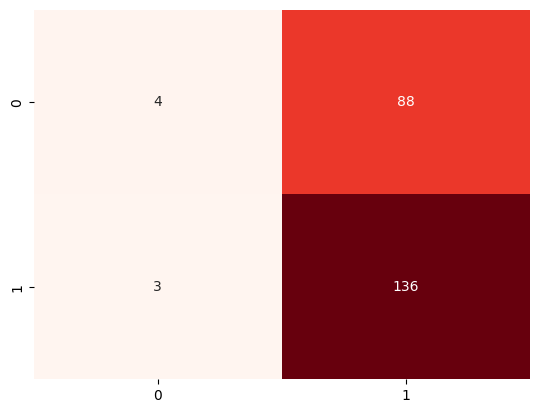

In [ ]:
#TEST ON THE TEST SET
best_model_forest = gs_forest.best_estimator_
y_pred_forest = best_model_forest.predict(X_test)
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_forest), annot=True, fmt='d', cmap="Reds", cbar=False);


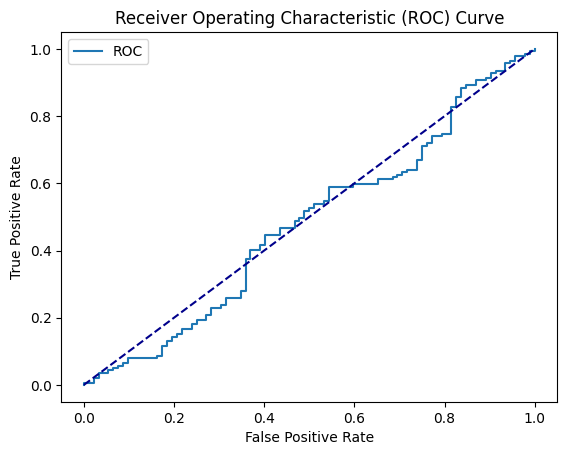

AUC: 0.48


In [ ]:
# ROC curve
y_probs_forest = best_model_forest.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr_forest, tpr_forest, thresholds_forest=metrics.roc_curve(y_test,  y_probs_forest[:,1])

plt.plot(fpr_forest, tpr_forest, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs_forest[:,1])
print('AUC: %.2f' % auc)

In [ ]:
print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred_forest)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred_forest)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred_forest)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_forest)) # (tp+tn)/m


***RESULTS ON TEST SET***
precision:  0.6071428571428571
recall:  0.9784172661870504
f1_score:  0.7493112947658402
accuracy:  0.6060606060606061


C:\Users\pietr\AppData\Local\Temp\ipykernel_14200\1929189169.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X_train.columns, y=best_model_forest.feature_importances_, palette="Blues_d")


<Axes: xlabel='None'>

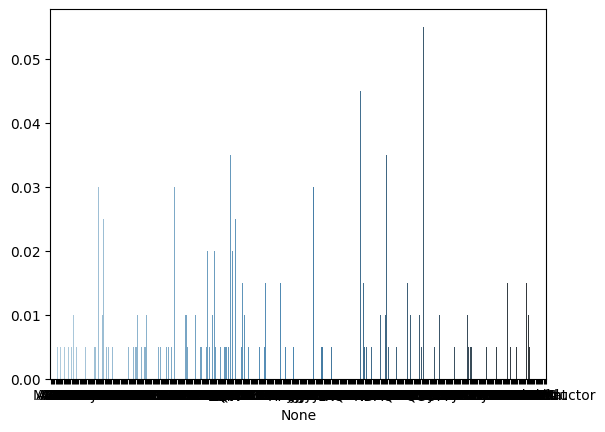

In [ ]:
sns.barplot(x=X_train.columns, y=best_model_forest.feature_importances_, palette="Blues_d")


### Remarks on Random Forest

This method as well performs almost like a random classifier

# Second Approach: one classifier for each edge

### Creating the dataframe for the classifier of AAPL

In [5]:
df_second = df1.copy()
col_names = []
for i,col in enumerate(col_stocks):
  if col.endswith(' '):
     s = f"y_{col[:-1]}"
  else:
     s = f"y_{col}"
  col_names.append(s)
y_second = pd.DataFrame(df1['AAPL']>0)
# y_second = y_second[col_stocks[0:430]]
# y_second.columns = col_names[0:430]
y_second

,AAPL
Date,
2010-01-15,False
2010-01-22,False
2010-01-29,False
2010-02-05,True
2010-02-12,True
...,...
2024-05-24,True
2024-05-31,True
2024-06-07,True


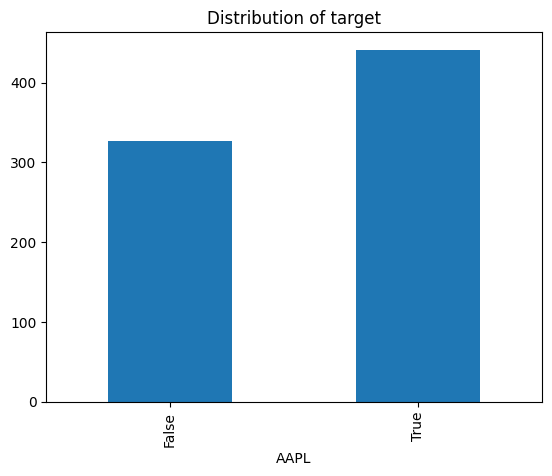

In [6]:
for i,col in enumerate(y_second.columns):
  target_dist=y_second.groupby(col).size()
  target_dist.plot.bar(x='',y='',title='Distribution of target')
  plt.show()

In [7]:
df1

,MMM,AOS,ABT,ACN,ADBE,AMD,AES,AFL,A,APD,...,WST _VOL,WDC _VOL,WY _VOL,WMB _VOL,WTW _VOL,WYNN _VOL,XEL _VOL,YUM _VOL,ZBRA _VOL,ZBH _VOL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,-0.011331,-0.020276,0.015238,0.005622,-0.022603,-0.064609,0.018692,0.033827,-0.012086,0.011300,...,1402800.0,16743100.0,4872800.0,36871442.0,1363832.0,15349000.0,14714500.0,28526629.0,606600.0,6031062.0
2010-01-22,-0.022931,-0.023021,-0.017819,-0.014825,-0.042426,-0.114959,-0.075424,-0.040121,-0.042288,-0.058460,...,578000.0,24088900.0,4917200.0,42622792.0,822685.0,8623900.0,10523100.0,15572523.0,601900.0,4376676.0
2010-01-29,-0.012225,-0.003809,-0.029225,-0.028618,-0.062408,-0.054772,-0.030412,-0.013740,-0.039865,-0.027399,...,1193800.0,24487000.0,8931800.0,53696517.0,2451183.0,11245300.0,15542400.0,22938565.0,1141000.0,12277497.0
2010-02-05,-0.024525,-0.021124,0.019270,-0.011039,0.014446,-0.014855,-0.073925,-0.016237,0.039865,-0.101332,...,1161600.0,19978300.0,13171100.0,57787169.0,2896783.0,11317900.0,15884400.0,39501618.0,993000.0,9129920.0
2010-02-12,0.008115,0.051654,-0.000742,-0.001234,-0.041114,0.068358,0.003404,-0.004800,0.027390,-0.001604,...,1364400.0,19402700.0,8364500.0,52931796.0,1196825.0,10613000.0,16262700.0,36774146.0,2937000.0,9209127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,-0.047648,-0.010560,-0.001346,-0.008601,-0.016687,0.011426,-0.017540,-0.002006,-0.023419,0.007244,...,2655100.0,21968200.0,14997000.0,26319000.0,1661900.0,6405500.0,15990700.0,6505200.0,1330400.0,4998800.0
2024-05-31,0.004704,-0.013538,-0.017076,-0.064142,-0.066685,0.003241,0.032003,0.024556,-0.144342,0.007868,...,2256600.0,26291800.0,13919900.0,22704700.0,2685200.0,7404100.0,20073900.0,7254200.0,1260600.0,7875800.0
2024-06-07,0.007164,-0.031086,0.051401,0.021413,0.045427,0.005795,-0.083019,-0.012090,0.019515,0.046985,...,2167000.0,23004900.0,15885100.0,29355600.0,1500100.0,6665900.0,15349500.0,8683300.0,1123200.0,5740200.0


In [8]:
data_weekly.iloc[:,-5:]

,Oil,Gold,Semiconductor,Wheat,Yuan
Date,,,,,
2010-01-15,-0.059115,-0.007403,-0.064593,-0.108175,-0.000088
2010-01-22,-0.045373,-0.036758,-0.045098,-0.023314,0.000000
2010-01-29,-0.022384,-0.005429,-0.041518,-0.051491,-0.000015
2010-02-05,-0.023599,-0.029020,0.012262,0.002111,0.000234
2010-02-12,0.040468,0.034724,0.039221,0.023965,0.000717
...,...,...,...,...,...
2024-05-24,-0.029664,-0.034859,0.046638,0.068250,0.002641
2024-05-31,-0.009437,0.000171,-0.018852,-0.027260,-0.000138
2024-06-07,-0.019146,-0.008906,0.031471,-0.044067,0.000828


In [14]:
X = df1.copy().iloc[range(df1.shape[0]-1),:]
X = pd.concat([X, data_weekly.iloc[:,-5:]], axis=1).drop(columns=['AAPL', 'AAPL _VOL']).iloc[:-1,:]
X

,MMM,AOS,ABT,ACN,ADBE,AMD,AES,AFL,A,APD,...,WYNN _VOL,XEL _VOL,YUM _VOL,ZBRA _VOL,ZBH _VOL,Oil,Gold,Semiconductor,Wheat,Yuan
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,-0.011331,-0.020276,0.015238,0.005622,-0.022603,-0.064609,0.018692,0.033827,-0.012086,0.011300,...,15349000.0,14714500.0,28526629.0,606600.0,6031062.0,-0.059115,-0.007403,-0.064593,-0.108175,-0.000088
2010-01-22,-0.022931,-0.023021,-0.017819,-0.014825,-0.042426,-0.114959,-0.075424,-0.040121,-0.042288,-0.058460,...,8623900.0,10523100.0,15572523.0,601900.0,4376676.0,-0.045373,-0.036758,-0.045098,-0.023314,0.000000
2010-01-29,-0.012225,-0.003809,-0.029225,-0.028618,-0.062408,-0.054772,-0.030412,-0.013740,-0.039865,-0.027399,...,11245300.0,15542400.0,22938565.0,1141000.0,12277497.0,-0.022384,-0.005429,-0.041518,-0.051491,-0.000015
2010-02-05,-0.024525,-0.021124,0.019270,-0.011039,0.014446,-0.014855,-0.073925,-0.016237,0.039865,-0.101332,...,11317900.0,15884400.0,39501618.0,993000.0,9129920.0,-0.023599,-0.029020,0.012262,0.002111,0.000234
2010-02-12,0.008115,0.051654,-0.000742,-0.001234,-0.041114,0.068358,0.003404,-0.004800,0.027390,-0.001604,...,10613000.0,16262700.0,36774146.0,2937000.0,9209127.0,0.040468,0.034724,0.039221,0.023965,0.000717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-17,0.062021,-0.008137,-0.006225,-0.008985,0.002361,0.079374,0.065040,0.026255,0.029411,0.047354,...,6098700.0,16056900.0,9499000.0,1177800.0,5840100.0,0.022740,0.017864,0.035751,0.008481,-0.000374
2024-05-24,-0.047648,-0.010560,-0.001346,-0.008601,-0.016687,0.011426,-0.017540,-0.002006,-0.023419,0.007244,...,6405500.0,15990700.0,6505200.0,1330400.0,4998800.0,-0.029664,-0.034859,0.046638,0.068250,0.002641
2024-05-31,0.004704,-0.013538,-0.017076,-0.064142,-0.066685,0.003241,0.032003,0.024556,-0.144342,0.007868,...,7404100.0,20073900.0,7254200.0,1260600.0,7875800.0,-0.009437,0.000171,-0.018852,-0.027260,-0.000138


In [13]:
y_second

,AAPL
Date,
2010-01-15,False
2010-01-22,False
2010-01-29,True
2010-02-05,True
2010-02-12,True
...,...
2024-05-17,True
2024-05-24,True
2024-05-31,True


In [11]:
index = y_second.index[:-1]
y_second = y_second.iloc[1:]
y_second.index = index
y_second

,AAPL
Date,
2010-01-15,False
2010-01-22,False
2010-01-29,True
2010-02-05,True
2010-02-12,True
...,...
2024-05-17,True
2024-05-24,True
2024-05-31,True


In [15]:
from sklearn.model_selection import train_test_split
#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y_second, test_size=0.3, shuffle=False)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(536, 868) (231, 868)
(536, 1) (231, 1)


## K-Nearest Neighbours

In [148]:
# DEFINE YOUR CLASSIFIER and THE PARAMETERS GRID
from sklearn.neighbors import KNeighborsClassifier

# Create KNN Classifier
classifier_KNN = KNeighborsClassifier()
parameters = {'n_neighbors': np.arange(60,90)}

gs_KNN = GridSearchCV(classifier_KNN, parameters, cv=3, scoring = 'f1', verbose=90, n_jobs=-1)

# TRAIN YOUR CLASSIFIER
gs_KNN = gs_KNN.fit(X_train, y_train)

# Summarize the results of your GRIDSEARCH
print("Best score: %f using %s" % (gs_KNN.best_score_, gs_KNN.best_params_))

means = gs_KNN.cv_results_['mean_test_score']
stds = gs_KNN.cv_results_['std_test_score']
params = gs_KNN.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean %f Std (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best score: 0.733956 using {'n_neighbors': 79}
Mean 0.708968 Std (0.015870) with: {'n_neighbors': 60}
Mean 0.715549 Std (0.017290) with: {'n_neighbors': 61}
Mean 0.704239 Std (0.014645) with: {'n_neighbors': 62}
Mean 0.711862 Std (0.013691) with: {'n_neighbors': 63}
Mean 0.704875 Std (0.019973) with: {'n_neighbors': 64}
Mean 0.718989 Std (0.012690) with: {'n_neighbors': 65}
Mean 0.704145 Std (0.012613) with: {'n_neighbors': 66}
Mean 0.706073 Std (0.012438) with: {'n_neighbors': 67}
Mean 0.699966 Std (0.011571) with: {'n_neighbors': 68}
Mean 0.716984 Std (0.007516) with: {'n_neighbors': 69}
Mean 0.707719 Std (0.003816) with: {'n_neighbors': 70}
Mean 0.719176 Std (0.008073) with: {'n_neighbors': 71}
Mean 0.712496 Std (0.006317) with: {'n_neighbors': 72}
Mean 0.724645 Std (0.004542) with: {'n_neighbors': 73}
Mean 0.713176 Std (0.007491) with: {'n_neighbors': 74}
Mean 0.729202 Std (0.003819) with: {'n_neighbors': 75}
Mean 0.72635

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


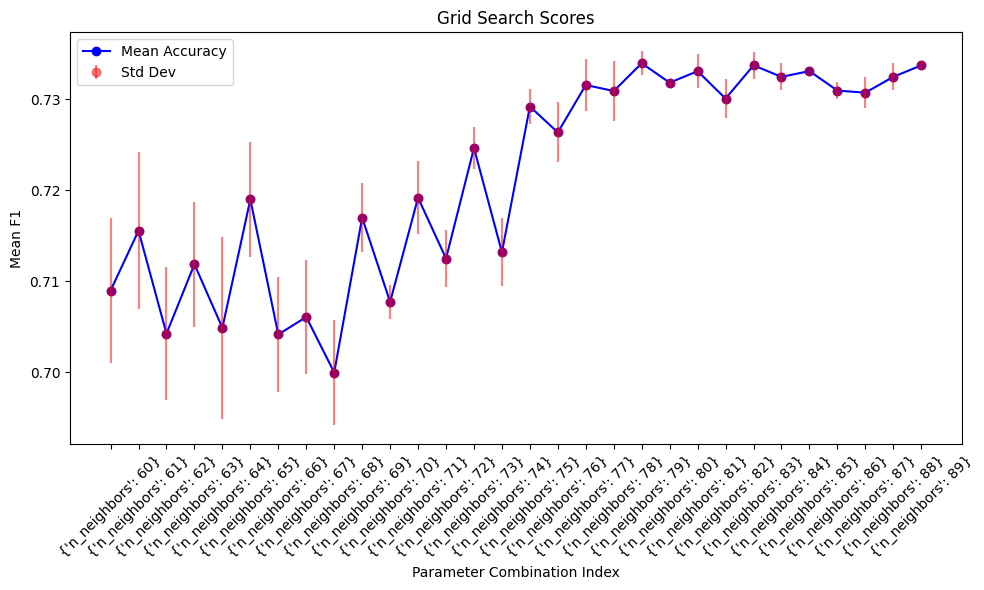

0.733955844530149


In [149]:
# Plot results of grid search
x_axis = range(len(params))

plt.figure(figsize=(10, 6))

# Plot mean accuracy scores
plt.plot(x_axis, means, color='blue', alpha=1.00, marker='o', label='Mean Accuracy')

# Add error bars (standard deviation)
plt.errorbar(x_axis, means, yerr=stds/2, fmt='o', color='red', alpha=0.5, label='Std Dev')

plt.title('Grid Search Scores')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean F1')
plt.xticks(x_axis, [str(p) for p in params], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(gs_KNN.best_score_)

In [150]:
# TEST ON YOUR TEST SET
best_model = gs_KNN.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

In [151]:
from sklearn import metrics

# EVALUATE YOUR PREDICTION IN THE TRAINING SET

print('***RESULTS ON TRAIN SET***')
print("precision: ", metrics.precision_score(y_train, y_pred_train)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_train, y_pred_train)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train)) # (tp+tn)/m

# EVALUATE YOUR PREDICTION IN THE TEST SET
print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred)) # (tp+tn)/m

# PRINT SOME FURTHER METRICS
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

***RESULTS ON TRAIN SET***
precision:  0.5813084112149532
recall:  1.0
f1_score:  0.7352245862884161
accuracy:  0.582089552238806
***RESULTS ON TEST SET***
precision:  0.5652173913043478
recall:  1.0
f1_score:  0.7222222222222222
accuracy:  0.5670995670995671
              precision    recall  f1-score   support

       False       1.00      0.01      0.02       101
        True       0.57      1.00      0.72       130

    accuracy                           0.57       231
   macro avg       0.78      0.50      0.37       231
weighted avg       0.76      0.57      0.42       231



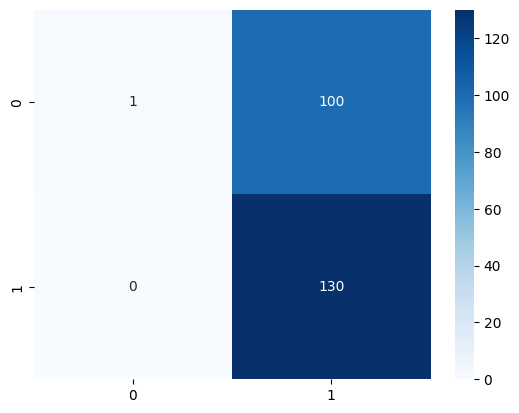

In [152]:
# Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format


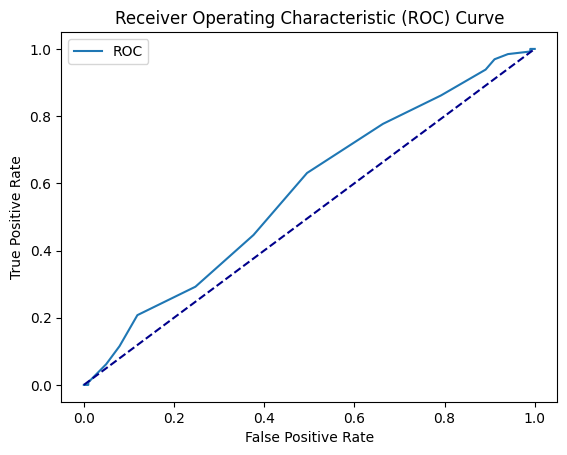

AUC: 0.57


In [153]:
y_test_probs = best_model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_test_probs[:,1])

# plot
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_test_probs[:,1])
print('AUC: %.2f' % auc)

## Decision Trees

In [160]:
from sklearn.tree import DecisionTreeClassifier
import random as rd


classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'],
              'max_depth': [10,50,150],
              'min_samples_split': [5,20,50],
              'min_samples_leaf': [2,4]}

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
***GRIDSEARCH RESULTS***
Best score: 0.583264 using {'criterion': 'gini', 'max_depth': 150, 'min_samples_leaf': 4, 'min_samples_split': 50}
0.547978 (0.047670) with: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.521712 (0.013816) with: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 20}
0.534244 (0.041062) with: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 50}
0.550453 (0.058107) with: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
0.511129 (0.010811) with: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 20}
0.534244 (0.041062) with: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 50}
0.567567 (0.036567) with: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_

***RESULTS ON TRAIN SET***
f1_score:  0.8637110016420361
--
***RESULTS ON TEST SET***
f1_score:  0.5361702127659576


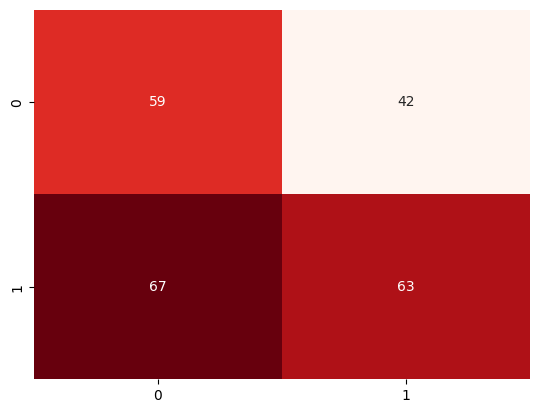

In [161]:
#TEST ON YOUR TEST SET
from sklearn import metrics
from sklearn.metrics import confusion_matrix
best_model_tree = gs.best_estimator_
y_pred_tree = best_model_tree.predict(X_test)
y_pred_train_tree = best_model_tree.predict(X_train)

print('***RESULTS ON TRAIN SET***')
print("f1_score: ", metrics.f1_score(y_train, y_pred_train_tree))
print("--")
print('***RESULTS ON TEST SET***')
print("f1_score: ", metrics.f1_score(y_test, y_pred_tree))
# Plot confusion matrix for every model
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt='d', cmap="Reds", cbar=False);
plt.show()

In [162]:
# Printing metrics for the model
print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred_tree)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred_tree)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred_tree)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_tree),'\n') # (tp+tn)/m


***RESULTS ON TEST SET***
precision:  0.6
recall:  0.4846153846153846
f1_score:  0.5361702127659576
accuracy:  0.5281385281385281 



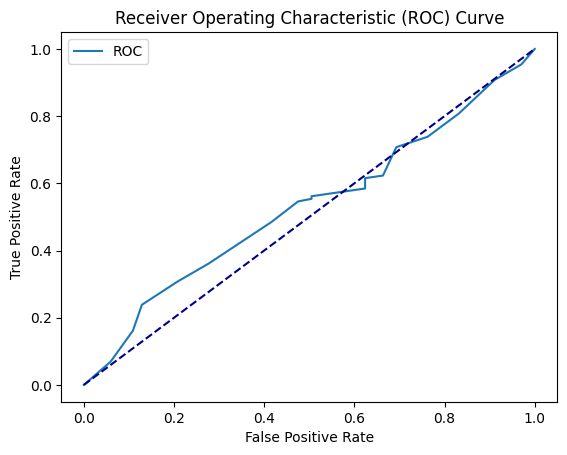

AUC: 0.53 



In [163]:
# Plotting the ROC curve for every model
y_probs_tree = best_model_tree.predict_proba(X_test)
fpr_tree, tpr_tree, thresholds_new_tree = metrics.roc_curve(y_test,  y_probs_tree[:,1])

# plot
plt.plot(fpr_tree, tpr_tree, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs_tree[:,1])
print(f'AUC: {auc:.2f}','\n')

## Support Vector Machine

In [154]:
from sklearn.svm import SVC
classifier = SVC()
parameters = {
    "kernel": ['linear', 'rbf'],
    "C": [.01, .1, 1],
    "gamma": [1],
    # "degree": [2, 3, 4]
}

gs_svm = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)

#TRAIN YOUR CLASSIFIER
gs_svm = gs_svm.fit(X_train, y_train)
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_svm.best_score_, gs_svm.best_params_))
means = gs_svm.cv_results_['mean_test_score']
stds = gs_svm.cv_results_['std_test_score']
params = gs_svm.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
***GRIDSEARCH RESULTS***
Best score: 0.734354 using {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
0.581560 (0.080328) with: {'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
0.734354 (0.000889) with: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
0.581560 (0.080328) with: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
0.734354 (0.000889) with: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.581560 (0.080328) with: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
0.734354 (0.000889) with: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


We can compare these two models and conclude that the best is the one using {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}

***RESULTS ON TRAIN SET***
f1_score:  0.7352245862884161
--
***RESULTS ON TEST SET***
f1_score:  0.7222222222222222


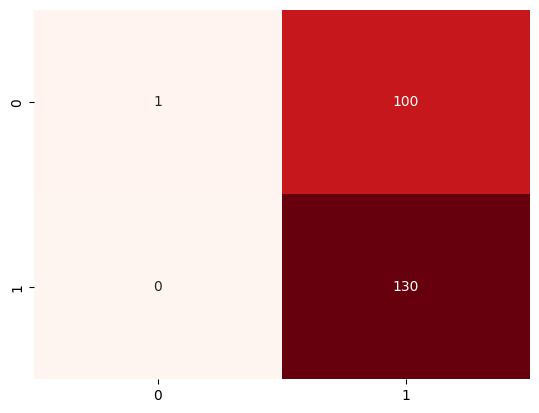

In [155]:
#TEST ON YOUR TEST SET
best_model_svm = gs_svm.best_estimator_
y_pred_svm = best_model.predict(X_test)

y_pred_train_svm = best_model.predict(X_train)

print('***RESULTS ON TRAIN SET***')
print("f1_score: ", metrics.f1_score(y_train, y_pred_train_svm))
print("--")
print('***RESULTS ON TEST SET***')
print("f1_score: ", metrics.f1_score(y_test, y_pred_svm))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap="Reds", cbar=False);

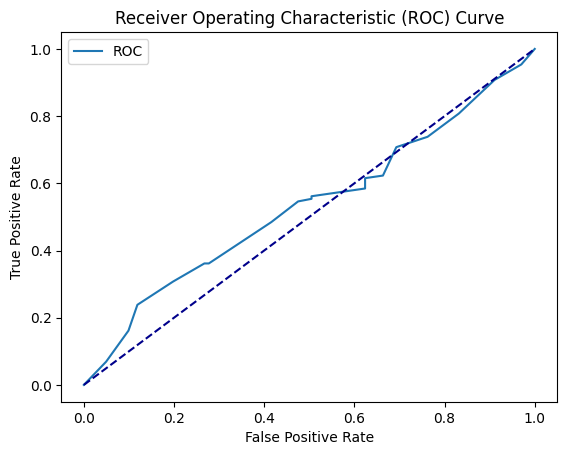

AUC: 0.57


In [156]:
y_probs_svm = best_model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr_svm, tpr_svm, thresholds_new_svm=metrics.roc_curve(y_test,  y_probs_svm[:,1])

# plot
plt.plot(fpr_tree, tpr_tree, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs_svm[:,1])
print('AUC: %.2f' % auc)

### Remark on SVM
With this data it's almost a random classifier, just like KNN and Decision Trees.

## Multi-Layer Perceptron Classifier

In [157]:
from sklearn.neural_network import MLPClassifier

classifier_mlp = MLPClassifier()
parameters_mlp = {"hidden_layer_sizes":[(200,100,50),(200,50)],"activation": ['logistic', 'tanh', 'relu'],  "max_iter": [500000], "alpha": [10,100]}

gs_mlp = GridSearchCV(classifier_mlp, parameters_mlp, cv=3, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)

#TRAIN YOUR CLASSIFIER
gs_mlp = gs_mlp.fit(X_train, y_train)

#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_mlp.best_score_, gs_mlp.best_params_))
means = gs_mlp.cv_results_['mean_test_score']
stds = gs_mlp.cv_results_['std_test_score']
params = gs_mlp.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


***GRIDSEARCH RESULTS***
Best score: 0.734598 using {'activation': 'tanh', 'alpha': 10, 'hidden_layer_sizes': (200, 50), 'max_iter': 500000}
0.734354 (0.000889) with: {'activation': 'logistic', 'alpha': 10, 'hidden_layer_sizes': (200, 100, 50), 'max_iter': 500000}
0.734354 (0.000889) with: {'activation': 'logistic', 'alpha': 10, 'hidden_layer_sizes': (200, 50), 'max_iter': 500000}
0.734354 (0.000889) with: {'activation': 'logistic', 'alpha': 100, 'hidden_layer_sizes': (200, 100, 50), 'max_iter': 500000}
0.734354 (0.000889) with: {'activation': 'logistic', 'alpha': 100, 'hidden_layer_sizes': (200, 50), 'max_iter': 500000}
0.734354 (0.000889) with: {'activation': 'tanh', 'alpha': 10, 'hidden_layer_sizes': (200, 100, 50), 'max_iter': 500000}
0.734598 (0.001103) with: {'activation': 'tanh', 'alpha': 10, 'hidden_layer_sizes': (200, 50), 'max_iter': 500000}
0.734354 (0.000889) with: {'activation': 'tanh', 'alpha': 100, 'hidden_layer_sizes': (200, 100, 50), 'max_iter': 500000}
0.734354 (0.000

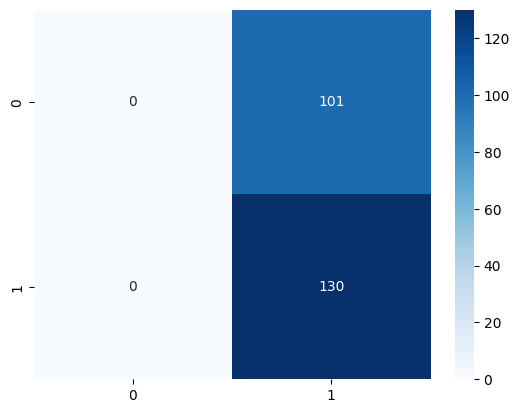

In [158]:
#TEST ON YOUR TEST SET
best_model_mlp = gs_mlp.best_estimator_

y_pred_mlp = best_model_mlp.predict(X_test)
y_pred_train_mlp = best_model_mlp.predict(X_train)

#CONFUSION MATRIX
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap="Blues");

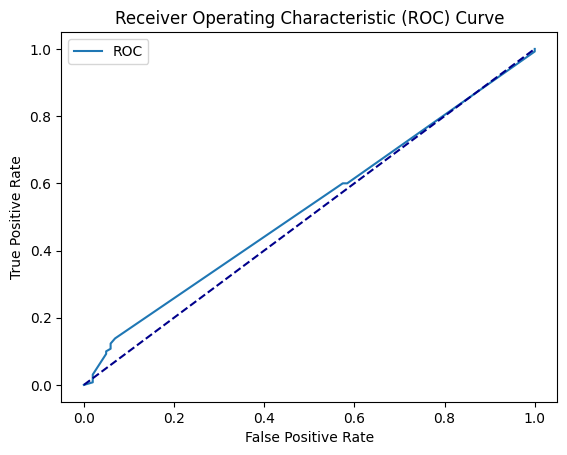

AUC: 0.53


In [159]:
y_probs_mlp = best_model_mlp.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr_mlp, tpr_mlp, thresholds_mlp=metrics.roc_curve(y_test,  y_probs_mlp[:,1])

plt.plot(fpr_mlp, tpr_mlp, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs_mlp[:,1])
print('AUC: %.2f' % auc)

### Remark on MLP

This method performs just like a random classifier: actually, it classifies every observation as a 1, thus we can safely exclude it from our selection.

## Kolmogorov-Arnold Network

In [38]:
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[3,10,1], grid=3, k=3, seed=42, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


In [39]:
X_train_kan = torch.tensor(X_train.values).to(device)
y_train_kan = torch.tensor(y_train.values).to(device)
X_test_kan = torch.tensor(X_test.values).to(device)
y_test_kan = torch.tensor(y_test.values).to(device)

In [40]:
dataset = {
    'train_input': X_train_kan,
    'train_label': y_train_kan.type(torch.float64),
    'test_input': X_test_kan,
    'test_label': y_test_kan.type(torch.float64)
}

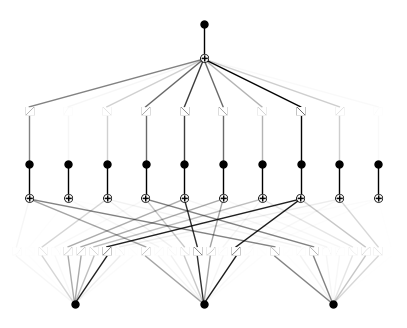

In [41]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot()

| train_loss: 4.67e-01 | test_loss: 5.39e-01 | reg: 9.15e+00 | : 100%|█| 50/50 [00:23<00:00,  2.17it


saving model version 0.1


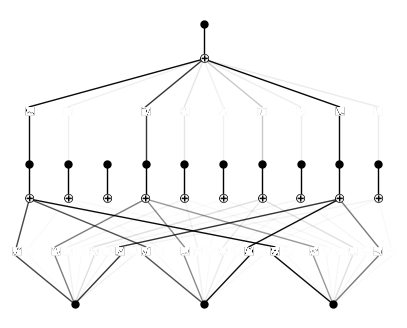

In [42]:
# train the model
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);
model.plot()

saving model version 0.2


| train_loss: 3.61e-01 | test_loss: 5.83e-01 | reg: 1.72e+01 | : 100%|█| 50/50 [00:22<00:00,  2.27it


saving model version 0.3


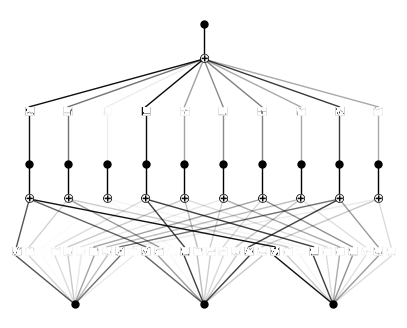

In [43]:
model = model.refine(10)
model.fit(dataset, opt="LBFGS", steps=50);
model.plot()

saving model version 0.4


| train_loss: 3.28e-01 | test_loss: 7.35e-01 | reg: 1.91e+01 | : 100%|█| 50/50 [00:24<00:00,  2.07it


saving model version 0.5


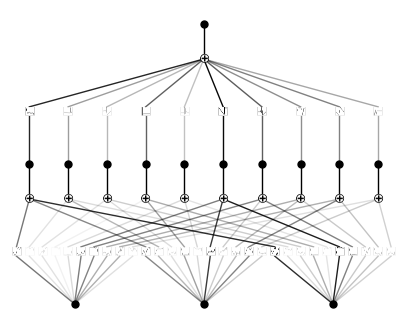

In [44]:
model = model.refine(10)
model.fit(dataset, opt="LBFGS", steps=50);
model.plot()

In [45]:
from kan.utils import ex_round

formula = ex_round(model.symbolic_formula()[0][0],4)
formula

0

In [46]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0])).astype(np.float64)) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor([0.4198])
test acc of the formula: tensor([0.4372])


In [47]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:]) == dataset['train_label'][:]).type(torch.float64))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:]) == dataset['test_label'][:]).type(torch.float64))

results = model.fit(dataset, opt="LBFGS", steps=50, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

| train_loss: 2.51e-01 | test_loss: 7.59e-01 | reg: 2.28e+01 | : 100%|█| 50/50 [00:25<00:00,  1.94it

saving model version 0.6


(0.9552238805970149, 0.5281385281385281)

In [48]:
formula = ex_round(model.symbolic_formula()[0][0],4)
formula

0

## Random Forest 2

In [164]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier_forest= RandomForestClassifier()
parameters = {'n_estimators' : [10,50,100],
            'criterion' : ['entropy','gini'],
             'max_depth' : [5,25],
             'min_samples_split' : [5,10],
              'min_samples_leaf' : [2]
             }

gs_forest = GridSearchCV(classifier_forest, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

gs_forest.fit(X_train,y_train)



Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [5, 25],
                         'min_samples_leaf': [2], 'min_samples_split': [5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring='f1', verbose=10)

In [165]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_forest.best_score_, gs_forest.best_params_))
means = gs_forest.cv_results_['mean_test_score']
stds = gs_forest.cv_results_['std_test_score']
params = gs_forest.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.689737 using {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.631202 (0.029864) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
0.671738 (0.017938) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
0.674314 (0.012957) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.656228 (0.013671) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}
0.666856 (0.027854) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.664982 (0.034414) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
0.576547 (0.036909) with: {'crite

In [166]:
#TEST ON YOUR TEST SET
best_model_forest = gs_forest.best_estimator_
y_pred_forest = best_model_forest.predict(X_test)

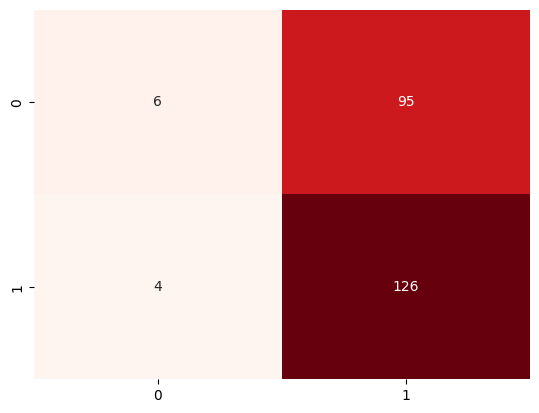

In [167]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_forest), annot=True, fmt='d', cmap="Reds", cbar=False);

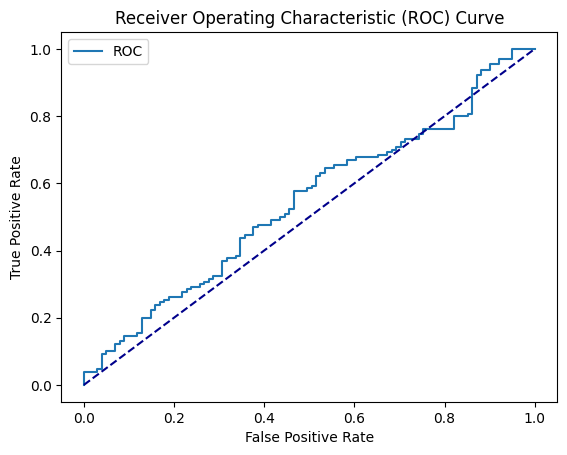

AUC: 0.54


In [168]:
# ROC curve

from sklearn import metrics

y_probs_forest = best_model_forest.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr_forest, tpr_forest, thresholds_forest=metrics.roc_curve(y_test,  y_probs_forest[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr_forest, tpr_forest, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs_forest[:,1])
print('AUC: %.2f' % auc)

In [169]:
print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred_forest)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred_forest)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred_forest)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_forest)) # (tp+tn)/m


***RESULTS ON TEST SET***
precision:  0.5701357466063348
recall:  0.9692307692307692
f1_score:  0.717948717948718
accuracy:  0.5714285714285714


<ipython-input-170-b23ae82a8210>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X_train.columns, y=best_model_forest.feature_importances_, palette="Blues_d")


<Axes: xlabel='None'>

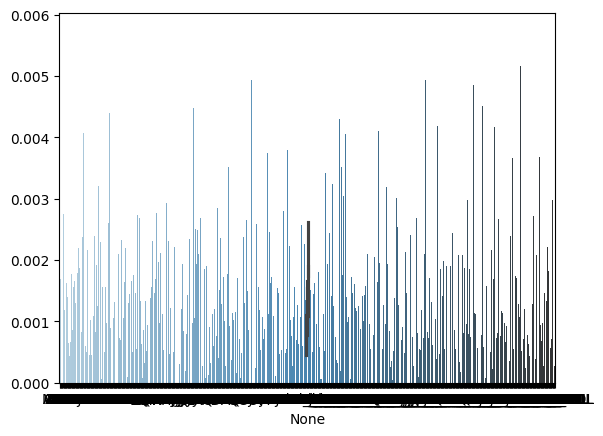

In [170]:
sns.barplot(x=X_train.columns, y=best_model_forest.feature_importances_, palette="Blues_d")


## AdaBoost 2

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

classifier_ada = AdaBoostClassifier()
parameters_ada = {'n_estimators' : [1000],
    'base_estimator' : [DecisionTreeClassifier(max_depth=10)],
    'learning_rate' : [0.0001, 0.1, 10]}

gs_ada = GridSearchCV(classifier_ada, parameters_ada, cv=3, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

gs_ada.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(cv=3, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=10)],
                         'learning_rate': [0.0001, 0.1, 10],
                         'n_estimators': [1000]},
             scoring='f1', verbose=10)

In [17]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs_ada.best_score_, gs_ada.best_params_))
means = gs_ada.cv_results_['mean_test_score']
stds = gs_ada.cv_results_['std_test_score']
params = gs_ada.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.542336 using {'base_estimator': DecisionTreeClassifier(max_depth=10), 'learning_rate': 0.0001, 'n_estimators': 1000}
0.542336 (0.043451) with: {'base_estimator': DecisionTreeClassifier(max_depth=10), 'learning_rate': 0.0001, 'n_estimators': 1000}
0.530216 (0.007404) with: {'base_estimator': DecisionTreeClassifier(max_depth=10), 'learning_rate': 0.1, 'n_estimators': 1000}
0.536961 (0.026322) with: {'base_estimator': DecisionTreeClassifier(max_depth=10), 'learning_rate': 10, 'n_estimators': 1000}


In [18]:
#TEST ON YOUR TEST SET
best_model_ada_gs = gs_ada.best_estimator_

y_pred_ada_gs = best_model_ada_gs.predict(X_test)
y_pred_train_ada_gs = best_model_ada_gs.predict(X_train)

In [19]:
from sklearn import metrics
print("f1_score_train: ", metrics.f1_score(y_train, y_pred_train_ada_gs))
print("f1_score_test: ", metrics.f1_score(y_test, y_pred_ada_gs))

f1_score_train:  1.0
f1_score_test:  0.3979591836734694


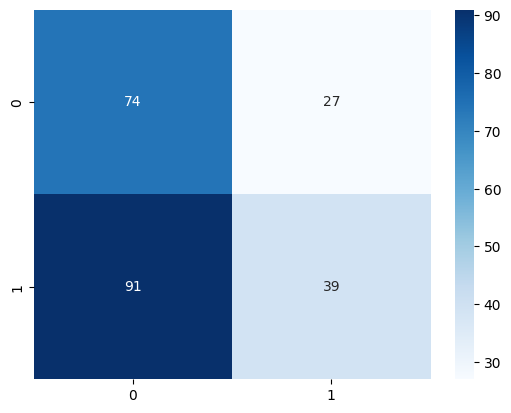

In [20]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred_ada_gs), annot=True, fmt='d', cmap="Blues");

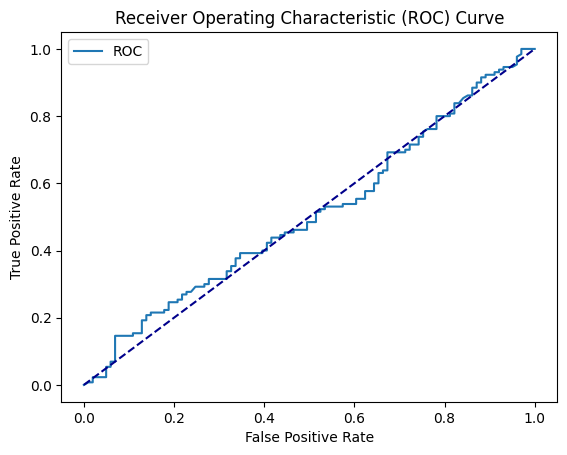

AUC: 0.51


In [21]:
from sklearn import metrics

y_probs_ada_gs = best_model_ada_gs.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr_ada_gs, tpr_ada_gs, thresholds_ada_gs=metrics.roc_curve(y_test,  y_probs_ada_gs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr_ada_gs, tpr_ada_gs, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs_ada_gs[:,1])
print('AUC: %.2f' % auc)